<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_18_Food_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Build a model to recognize the food**

The training dataset contains 5400 images of burgers, pizza and soft drinks. You can download the training and testing dataset from the given link:

Dataset Link: https://drive.google.com/file/d/1xFLxi8Akn1iRQ6jFW2A4-jBBHZxup21b/view?usp=sharing

From the above link you will be able to download a zip file named ‘food_classifier_data.zip’. After you extract this zip file, you will get four files:

* train - contains all the food images that are to be used for training your model.  * * Each image has a unique name.
* Training_set_covid.csv - this csv file contains all the image ids present in the train folder with their respective label of burgers, pizza or softdrinks
* test - contains food images. For these images you are required to make predictions as burger, pizza or softdrink
* Testing_set_covid.csv - this is the order of the predictions for each image that is to be submitted on the platform. 

* Make sure the predictions you download are with their image’s filename in the same order as given in this file.
* sample_submission: This is a csv file that contains the sample submission for the data sprint.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Download Data**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1xFLxi8Akn1iRQ6jFW2A4-jBBHZxup21b',
dest_path='content/food_classifier_data.zip',
unzip=True)

Unzipping...Done.


In [2]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
labels = pd.read_csv("/content/content/food_classifier_data/Training_set_food.csv")
labels.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [17]:
labels = pd.read_csv("/content/content/food_classifier_data/Training_set_food.csv")

labels.head() 
file_paths = [[fname, '/content/content/food_classifier_data/train/' + fname] for fname in labels['filename']]

if len(labels) == len(file_paths):
  print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

Number of labels i.e.  5400 matches the number of filenames i.e.  5400


,filename,filepaths,label
0,Image_1.jpg,/content/content/food_classifier_data/train/Im...,burgers
1,Image_2.jpg,/content/content/food_classifier_data/train/Im...,burgers
2,Image_3.jpg,/content/content/food_classifier_data/train/Im...,burgers
3,Image_4.jpg,/content/content/food_classifier_data/train/Im...,burgers
4,Image_5.jpg,/content/content/food_classifier_data/train/Im...,burgers


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


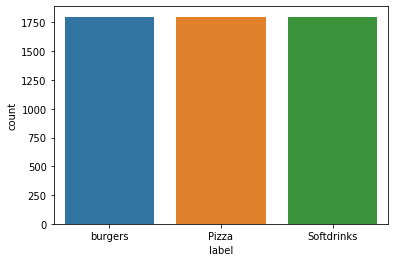

In [7]:
sns.countplot(train_data['label'])

In [18]:
test_image_order = pd.read_csv("/content/content/food_classifier_data/Testing_set_food.csv")
test_image_order.head()

file_paths_test = [[fname, '/content/content/food_classifier_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/food_classifier_data/test/Ima...
1,Image_2.jpg,/content/content/food_classifier_data/test/Ima...
2,Image_3.jpg,/content/content/food_classifier_data/test/Ima...
3,Image_4.jpg,/content/content/food_classifier_data/test/Ima...
4,Image_5.jpg,/content/content/food_classifier_data/test/Ima...


In [24]:
train = train_data[['filename','label']].copy()
test = test_images[['filename']].copy()

In [20]:
train.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [21]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.tracker import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

#
import warnings
warnings.filterwarnings('ignore')
#
np.random.seed(1786)
ROOT = "/content/content/food_classifier_data"

In [22]:
##transformations to be done to images
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=20.0, max_zoom=1.3, max_lighting=0.5, max_warp=0.1, p_affine=0.2,
                      p_lighting=0.55)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))
data_folder = "/content/content/food_classifier_data"
## create databunch of test set to be passed
test_img = ImageList.from_df(test, path=data_folder, folder='test')

In [25]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train, path=data_folder, folder='train')
       .split_by_rand_pct(0.10)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

In [26]:
data = (src.transform(tfms, size=224,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

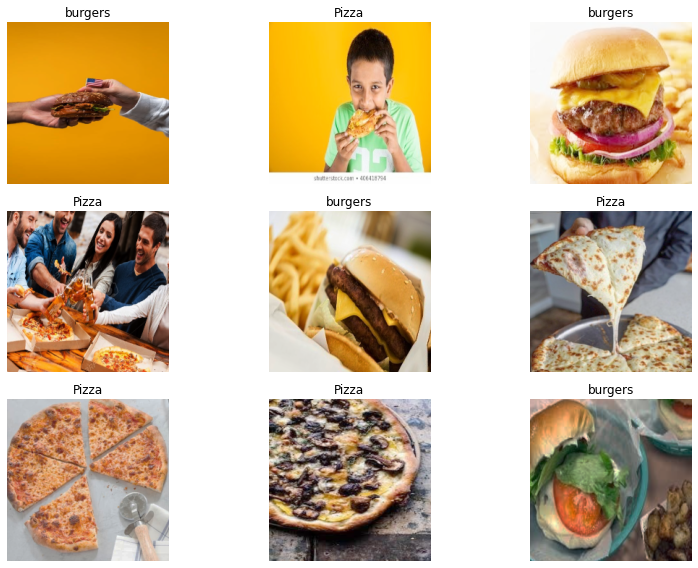

In [27]:
data.show_batch(3,figsize=(12,8))

In [28]:
data.classes

['Pizza', 'Softdrinks', 'burgers']

In [16]:
learn = cnn_learner(data=data, base_arch=models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 4.79E-03


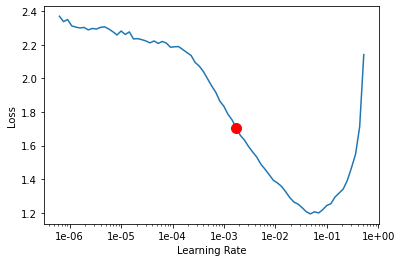

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.001737800828749376

In [19]:
learn.fit_one_cycle(5,max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.302416,0.122014,0.962963,01:06
1,0.258225,0.132637,0.959259,01:07
2,0.215584,0.074916,0.981481,01:07
3,0.098435,0.066278,0.985185,01:06
4,0.071815,0.061576,0.987037,01:07


In [23]:
learn.fit_one_cycle(20,min_grad_lr, callbacks=[ReduceLROnPlateauCallback(learn, monitor='valid_loss', mode='auto', patience=1, factor=0.2, min_delta=1, min_lr=0.001)])

epoch,train_loss,valid_loss,accuracy,time
0,0.636012,0.207452,0.918519,01:02
1,0.339203,0.112158,0.955556,01:03
2,0.205181,0.085844,0.964815,01:02
3,0.173563,0.074720,0.974074,01:01
4,0.137630,0.096486,0.966667,01:01
5,0.123747,0.073172,0.977778,01:01
6,0.102511,0.059127,0.987037,01:02
7,0.095467,0.069380,0.979630,01:03
8,0.086133,0.072374,0.979630,01:02
9,0.059513,0.070045,0.983333,01:03


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 6.31E-08


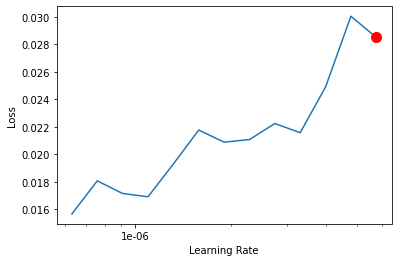

In [32]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [33]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

5.754399373371569e-06

In [34]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.155162,0.247430,0.927778,01:09
1,0.190099,0.212249,0.929630,01:09
2,0.171516,0.148359,0.933333,01:08
3,0.085737,0.088582,0.977778,01:09
4,0.037722,0.066674,0.979630,01:07


In [35]:
learn.fit_one_cycle(5,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.029945,0.066043,0.979630,01:04
1,0.026689,0.068996,0.975926,01:03
2,0.018759,0.067444,0.983333,01:04
3,0.021468,0.069384,0.979630,01:05
4,0.019311,0.069285,0.979630,01:04


In [20]:
from sklearn.metrics import accuracy_score,confusion_matrix
val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
val_preds = np.exp(val_preds.numpy())
print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
print("Accuracy Score ",accuracy_score(y.numpy(), np.argmax(val_preds,axis=1)))

F1 score for this fold  0.9851885913732451
Accuracy Score  0.9851851851851852


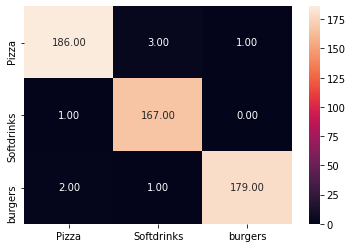

In [22]:
cf = confusion_matrix(y.numpy(), np.argmax(val_preds,axis=1))
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=data.classes,yticklabels=data.classes)

**Evaluation After Unfreeze**

F1 score for this fold  0.9796685620671164
Accuracy Score  0.9796296296296296


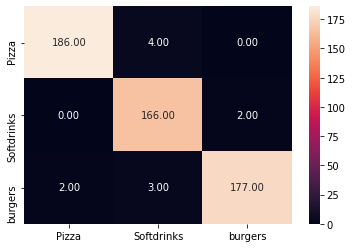

In [36]:
from sklearn.metrics import accuracy_score,confusion_matrix
val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
val_preds = np.exp(val_preds.numpy())
print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
print("Accuracy Score ",accuracy_score(y.numpy(), np.argmax(val_preds,axis=1)))

#
cf = confusion_matrix(y.numpy(), np.argmax(val_preds,axis=1))
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=data.classes,yticklabels=data.classes)

**Predictions before unfreeze**

In [23]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [24]:
df = pd.DataFrame({'image_id':test['filename'], 'label':labelled_preds})
df.head()

,image_id,label
0,Image_1.jpg,2
1,Image_2.jpg,2
2,Image_3.jpg,2
3,Image_4.jpg,3
4,Image_5.jpg,2


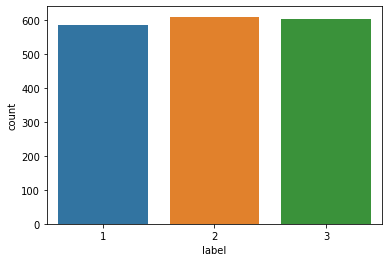

In [25]:
sns.countplot(df['label'])

In [28]:
df['prediction'] =df['label'].apply(lambda x : data.classes[x-1])

In [29]:
df.head()

,image_id,label,prediction
0,Image_1.jpg,2,Softdrinks
1,Image_2.jpg,2,Softdrinks
2,Image_3.jpg,2,Softdrinks
3,Image_4.jpg,3,burgers
4,Image_5.jpg,2,Softdrinks


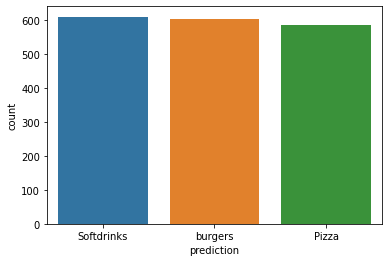

In [30]:
sns.countplot(df['prediction'])

In [31]:
df[['prediction']].to_csv("resnet34.csv",index=False)

#### **Predictions after unfreeze**

      image_id  label
0  Image_1.jpg      2
1  Image_2.jpg      2
2  Image_3.jpg      2
3  Image_4.jpg      3
4  Image_5.jpg      2
      image_id  label  prediction
0  Image_1.jpg      2  Softdrinks
1  Image_2.jpg      2  Softdrinks
2  Image_3.jpg      2  Softdrinks
3  Image_4.jpg      3     burgers
4  Image_5.jpg      2  Softdrinks


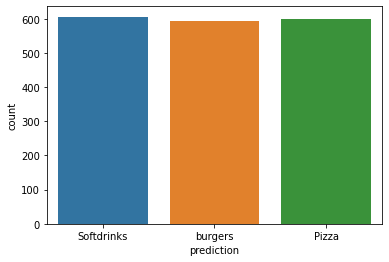

In [37]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)
#
df = pd.DataFrame({'image_id':test['filename'], 'label':labelled_preds})
print(df.head())
#
df['prediction'] =df['label'].apply(lambda x : data.classes[x-1])
print(df.head())
sns.countplot(df['prediction'])

In [38]:
df[['prediction']].to_csv("resnet34_unfreeze.csv",index=False)

* **Score before unfreeze 97.72222222222223**
* **Score after unfreeze 97.88888888888889**

In [27]:
sub = pd.read_csv("/content/content/food_classifier_data/sample_submission.csv")
sub.head()

,prediction
0,Softdrinks
1,Softdrinks
2,Softdrinks
3,Softdrinks
4,Softdrinks


**Fine Tuning**

In [29]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [30]:
train.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [31]:
import numpy as np
train_df = train.copy()
test_df = test.copy()
ROOT = "/content/content/food_classifier_data/"

(5400, 2) (1800, 1)
Starting fold 0
(5062,) (338,)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 4.79E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.318566,0.070509,0.970414,01:12
1,0.187971,0.084616,0.973373,01:12
2,0.115594,0.052445,0.976331,01:13
3,0.093715,0.065556,0.967456,01:14
4,0.070202,0.056301,0.970414,01:12


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 5.75E-07


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.074376,0.058278,0.973373,01:12
1,0.050476,0.053050,0.973373,01:13
2,0.068295,0.055127,0.973373,01:13
3,0.064224,0.056328,0.973373,01:13
4,0.051986,0.051730,0.973373,01:13
5,0.065500,0.052709,0.973373,01:13


Save the best acc 0.97337
Save the best acc 0.97337
Save the best acc 0.97337


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.058941,0.048955,0.979290,01:13
1,0.057981,0.049346,0.976331,01:11
2,0.051176,0.050488,0.979290,01:11
3,0.039359,0.046889,0.976331,01:11


Save the best acc 0.97929
Save the best acc 0.97633


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.047519,0.054062,0.973373,01:11
1,0.043075,0.048909,0.976331,01:11
2,0.044139,0.050197,0.976331,01:11


F1 score for this fold  0.9852047522328783


Starting fold 1
(5062,) (338,)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 4.79E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.270686,0.155683,0.937870,01:09
1,0.185180,0.121409,0.958580,01:09
2,0.113430,0.083051,0.982249,01:08
3,0.088715,0.093508,0.964497,01:08
4,0.059101,0.086055,0.970414,01:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-08


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.060121,0.081679,0.973373,01:11
1,0.044061,0.072601,0.967456,01:11
2,0.044665,0.074851,0.973373,01:11
3,0.041097,0.075515,0.973373,01:11
4,0.035697,0.073208,0.979290,01:11
5,0.041651,0.079948,0.973373,01:11


Save the best acc 0.97337
Save the best acc 0.96746
Save the best acc 0.97337
Save the best acc 0.97929


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.035593,0.069980,0.976331,01:10
1,0.045308,0.070965,0.982249,01:10
2,0.036113,0.069371,0.976331,01:11
3,0.036565,0.077007,0.973373,01:10


Save the best acc 0.97633
Save the best acc 0.98225
Save the best acc 0.97633


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.029887,0.068571,0.979290,01:10
1,0.034587,0.068911,0.979290,01:13
2,0.030638,0.067114,0.979290,01:13


Save the best acc 0.97929
Save the best acc 0.97929


F1 score for this fold  0.9910972568890433


Starting fold 2
(5062,) (338,)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 3.31E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.378835,0.133921,0.961538,01:09
1,0.195059,0.072241,0.982249,01:08
2,0.160640,0.062857,0.976331,01:08
3,0.112061,0.055354,0.985207,01:08
4,0.102529,0.057758,0.991124,01:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.111919,0.061212,0.985207,01:11
1,0.086237,0.057270,0.982249,01:11
2,0.080575,0.056984,0.991124,01:10
3,0.079824,0.056210,0.991124,01:11
4,0.081787,0.057039,0.988166,01:13
5,0.086233,0.057094,0.988166,01:11


Save the best acc 0.98521
Save the best acc 0.98225
Save the best acc 0.99112
Save the best acc 0.99112


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.098416,0.057958,0.985207,01:12
1,0.073317,0.053534,0.988166,01:11
2,0.086426,0.054444,0.988166,01:12
3,0.079575,0.057479,0.985207,01:11


Save the best acc 0.98817


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.089147,0.057284,0.985207,01:11
1,0.082634,0.057484,0.991124,01:11
2,0.083185,0.057701,0.988166,01:11


Save the best acc 0.99112


F1 score for this fold  0.9911110531849265


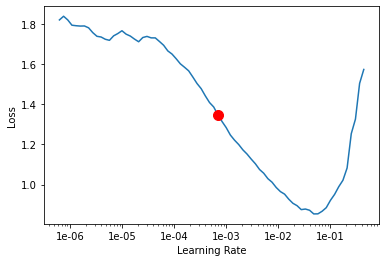

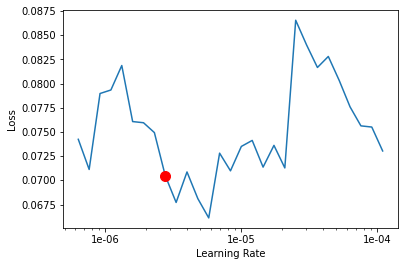

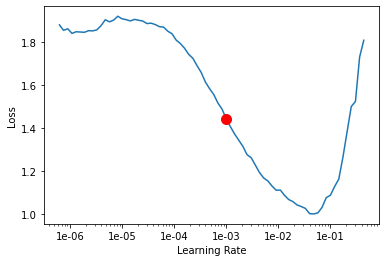

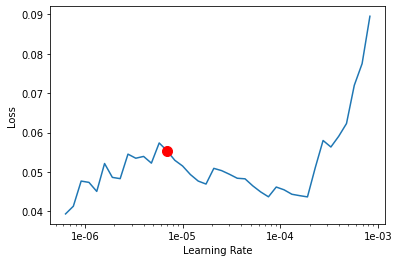

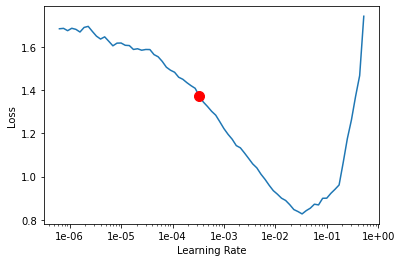

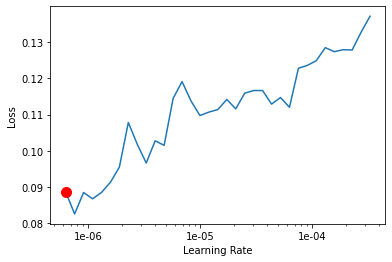

In [32]:
if __name__=="__main__":
    #train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(3):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet201, metrics=[FBeta(beta=1, average='macro'), accuracy], ps=0.2)
        learn = cnn_learner(data, models.resnet34, metrics=accuracy, ps=0.2)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.lr_find()
        learn.recorder.plot(suggestion=True)
        min_grad_lr = learn.recorder.min_grad_lr
        learn.fit_one_cycle(5,min_grad_lr)
        learn.unfreeze()
        learn.lr_find()
        learn.recorder.plot(suggestion=True)
        min_grad_lr = learn.recorder.min_grad_lr
        learn.fit_one_cycle(6, min_grad_lr , callbacks=[cb])
        #learn.fit_one_cycle(5, max_lr=1e-4/8, callbacks=[cb,ReduceLROnPlateauCallback(learn, monitor='valid_loss', mode='auto', patience=1, factor=0.2, min_delta=1, min_lr=0.001)])
        learn.fit_one_cycle(4, min_grad_lr , callbacks=[cb])
        #learn.fit_one_cycle(3, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(3, min_grad_lr , callbacks=[cb])
        #learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)


In [33]:
x = np.argmax(test_preds, axis=1)
x

array([1, 1, 1, 2, ..., 0, 0, 1, 1])

In [34]:
submission = pd.DataFrame({
        "filename":test_df['filename'],
        "label":x
    })

print(submission)

            filename  label
0        Image_1.jpg      1
1        Image_2.jpg      1
2        Image_3.jpg      1
3        Image_4.jpg      2
4        Image_5.jpg      1
...              ...    ...
1795  Image_1796.jpg      0
1796  Image_1797.jpg      0
1797  Image_1798.jpg      0
1798  Image_1799.jpg      1
1799  Image_1800.jpg      1

[1800 rows x 2 columns]


      filename  label  prediction
0  Image_1.jpg      1  Softdrinks
1  Image_2.jpg      1  Softdrinks
2  Image_3.jpg      1  Softdrinks
3  Image_4.jpg      2     burgers
4  Image_5.jpg      1  Softdrinks


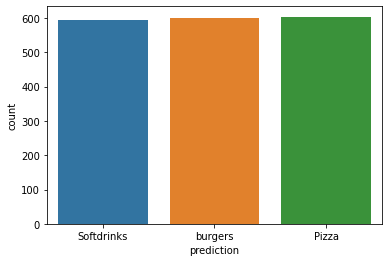

In [35]:
submission['prediction'] =submission['label'].apply(lambda x : data.classes[x])
print(submission.head())
sns.countplot(submission['prediction'])

In [36]:
submission[['prediction']].to_csv("stratifiedkfold.csv",index=False)

**Dphi Score : 98.05555555555556**